In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import os
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [26]:
def dict_product(dicts):
    result = []
    for d in dicts:
        result += list((dict(zip(d, x))) for x in product(*d.values()))
    return result

In [27]:
def samples_num_in_window(frequency, window_size_ms):
    return int(window_size_ms * frequency / 1000)

In [28]:
def emg_data_windowing(data, window_size):
    data_win = np.copy(data)
    data_x = data_win[:,:-1]
    data_y = data_win[:,-1]
    n, m = data_x.shape
    size = n * m
    residual_rows_num =  n % window_size
    if residual_rows_num != 0:
        data_x = data_x[:-residual_rows_num,:]
        data_y = data_y[:-residual_rows_num]
    data_x = data_x.reshape((-1, m * window_size))
    
    data_y = data_y.reshape((-1, window_size))
    data_y = np.array(list(map(np.mean, data_y)))
    
    mixed_classes_idxs = np.where(data_y % 1 != 0)
    
    data_win = np.c_[data_x, data_y]
    data_win = np.delete(data_win, mixed_classes_idxs, 0)
    
    return data_win

In [29]:
def read_emg(data_path):
    sessions_csv = []
    for path, _, files in os.walk(data_path):
        for name in files:
            sessions_csv.append(os.path.join(path, name))

    data = pd.concat([pd.read_csv(file, header = None) for file in sessions_csv]).values
    print('input shape', data.shape)
    
    # reshape data
    # one column - one channel
    data_x = data[:,:-1]
    data_y = data[:,-1]
    data_x = data_x.reshape((-1, 8))
    data_y = data_y.repeat(8)
    data_y = data_y.reshape((-1,1))
    data = np.concatenate((data_x, data_y), axis=1)
    print('result shape: ', data.shape)

    return data

In [30]:
from nitime.algorithms.autoregressive import AR_est_LD
from sklearn.preprocessing import StandardScaler

def autoregression_coefficients(emg, order):
    coef = AR_est_LD(emg, order=order)[0]
    return coef

In [31]:
import math

def integrated_absolute_value(segment):
    return sum([abs(s) for s in segment])

def mean_absolute_value(segment):
    return sum([abs(s) for s in segment])/len(segment)

def waveform_length(segment):
    n = len(segment)
    wl = 0
    for i in range(1, n):
        wl += abs(segment[i] - segment[i-1])
    return wl

def zero_crossing(segment):
    n = len(segment)
    zc = 0
    for i in range(n - 1):
        if segment[i] * segment[i+1] < 0:
            zc += 1
    return zc

def slope_sign_changes(segment):
    n = len(segment)
    ssc = 0
    for i in range(1, n-1):
        if segment[i-1] < segment[i] and segment[i] > segment[i+1] or segment[i-1] > segment[i] and segment[i] < segment[i+1]:
            ssc += 1
    return ssc

def root_mean_square(segment):
    return math.sqrt(sum([s*s for s in segment])/len(segment))

In [32]:
def calculate_features(data_x, channels_num, ar_features=True):
    n, m = data_x.shape
    features = []
    
    for channel in range(channels_num):
        channel_features = []
        
        # Calculate MAV, ZC, SSC, WL, RMS features
        channel_features.append(list(map(mean_absolute_value, data_x[:,channel::channels_num])))
        channel_features.append(list(map(waveform_length, data_x[:,channel::channels_num])))
        channel_features.append(list(map(zero_crossing, data_x[:,channel::channels_num])))
        channel_features.append(list(map(slope_sign_changes, data_x[:,channel::channels_num])))
        channel_features.append(list(map(root_mean_square, data_x[:,channel::channels_num])))
        
        if ar_features:
            # calculate AR6 coefficients
            ar_order = 6
            ar_coef = np.array(list(map(lambda x: autoregression_coefficients(x, ar_order), data_x[:,channel::channels_num])))
            channel_features += ar_coef.transpose().tolist()
        
        features += channel_features
    
    return np.array(features).transpose()

In [33]:
def gesture_classification(train, test, input_frequency, window_size_ms, classifier, ar_features=True):
    window_samples = samples_num_in_window(input_frequency, window_size_ms)
    train_win = emg_data_windowing(train, window_samples)
    test_win = emg_data_windowing(test, window_samples)
    
    train_x = train_win[:,:-1]
    train_y = train_win[:,-1].astype('int')
    test_x = test_win[:,:-1]
    test_y = test_win[:,-1].astype('int') 
    
    train_features = calculate_features(train_x, 8, ar_features)
    test_features = calculate_features(test_x, 8, ar_features)
    
    scaler = StandardScaler()
    scaler.fit(train_features)
    train_features = scaler.transform(train_features)
    test_features = scaler.transform(test_features)
    
    classifier.fit(train_features, train_y)
    pred = classifier.predict(test_features)
    
    return metrics.accuracy_score(test_y, pred)

In [34]:
def GridSearchOnSessions(estimator, param_grid, data):
    datasets_num = data.shape[0]
    if datasets_num == 0:
        raise ValueError('Data is empty')
    sessions_num = data.shape[1]
    print('datasets_num = {}'.format(datasets_num))
    print('sessions_num = {}'.format(sessions_num))
    
    param_grid_product = dict_product(param_grid)
    param_grid_results = []
    for params in param_grid_product:
#         print(params)
        estimator.set_params(**params)
        params_results = []
        for i, d in enumerate(data):
#             print('dataset {}'.format(i))
            d_results = []
            for train_sessions_num in range(1, sessions_num):
                train = np.concatenate(d[:train_sessions_num])
                validate = d[train_sessions_num]
                train_X = train[:,:-1]
                train_y = train[:,-1]
                validate_X = validate[:,:-1]
                validate_y = validate[:,-1]
                
                scaler = StandardScaler()
                scaler.fit(train_X)
                train_X = scaler.transform(train_X)
                validate_X = scaler.transform(validate_X)
                
                estimator.fit(train_X, train_y)
                pred = estimator.predict(validate_X)
                acc = metrics.accuracy_score(validate_y, pred)
                d_results.append(acc)
#                 print('number of sessions in train: {}, accuracy: {}'.format(train_sessions_num, acc))
            d_results_mean = np.mean(d_results)
            params_results.append(d_results_mean)
#             print('d_results_mean: {}', d_results_mean)
        params_results_mean = np.mean(params_results)
        param_grid_results.append([params, params_results_mean] + params_results)
#         print('params_results_mean: {}',format(params_results_mean))
#         print()
    return param_grid_results

In [35]:
def param_selection_logistic_regression(test, validate):
    clf = RidgeClassifier()
    alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 2]
    
    test_size = test.shape[0]
    data = np.concatenate((test, validate))
    X_data = data[:,:-1]
    y_data = data[:,-1].astype('int')
    train_indices = list(range(test_size))
    validate_indices = list(range(test_size, data.shape[0]))
    split = [(train_indices, validate_indices)]
    param_grid = dict(alpha=alphas)
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=split)
    grid_result = grid.fit(X_data, y_data)
    return grid_result

In [36]:
random.seed(101)

# prepare data
datasets_path = 'data/gestures-9/'
datasets = []
for dataset_name in list(os.walk(datasets_path))[0][1]:
    dataset_path = datasets_path + dataset_name
    print(dataset_path)
    session_names = list(os.walk(dataset_path))[0][1]
    sessions = []
    for session_name in session_names:
        current_session = os.path.join(dataset_path, session_name)
        print(current_session)
        sessions.append(read_emg(current_session))
    datasets.append(sessions)
    print()

data/gestures-9/p001
data/gestures-9/p001\session1
input shape (2250, 65)
result shape:  (18000, 9)
data/gestures-9/p001\session2
input shape (2250, 65)
result shape:  (18000, 9)
data/gestures-9/p001\session3
input shape (2250, 65)
result shape:  (18000, 9)

data/gestures-9/p002
data/gestures-9/p002\session1
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p002\session2
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p002\session3
input shape (2251, 65)
result shape:  (18008, 9)

data/gestures-9/p003
data/gestures-9/p003\session1
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p003\session2
input shape (2251, 65)
result shape:  (18008, 9)
data/gestures-9/p003\session3
input shape (2251, 65)
result shape:  (18008, 9)



In [37]:
preprocessed_datasets = []
for dataset in datasets:
    preprocessed_sessions = []
    for session in dataset:
        window_samples = samples_num_in_window(200, 200)
        session_win = emg_data_windowing(session, window_samples)

        session_X = session_win[:,:-1]
        session_y = session_win[:,-1].astype('int')

        session_features_X = calculate_features(session_X, 8, True)
        # Concatenate X and y
        session_features = np.c_[session_features_X, session_y]
        preprocessed_sessions.append(session_features)
    preprocessed_datasets.append(preprocessed_sessions)


In [38]:
data = np.array([np.array(d[:2]) for d in preprocessed_datasets])
print(data.shape)

best_results = dict()

# Logistic regression
clf_reg = LogisticRegression()
param_grid_reg = [{'C':[0.0001, 0.001, 0.01, 0.1, 1, 2],
                  'penalty':['l1','l2']}]
results_reg = GridSearchOnSessions(clf_reg, param_grid_reg, data)
results_reg = sorted(results_reg, key=lambda x: -x[1])
best_results['LogisticRegression'] = results_reg[0]

# SVM
clf_svm = svm.SVC()
param_grid_svm = [{'C':[0.001, 0.01, 0.1, 1, 10], 
              'gamma':[1e-4, 1e-3, 1e-2, 1e-1], 
              'kernel':['rbf', 'poly']},
             {'C':[0.001, 0.01, 0.1, 1, 10],
              'kernel':['linear']}]
results_svm = GridSearchOnSessions(clf_svm, param_grid_svm, data)
results_svm = sorted(results_svm, key=lambda x: -x[1])
best_results['SVM'] = results_svm[0]

# KNN
clf_knn = KNeighborsClassifier()
param_grid_knn = [{'n_neighbors': [3, 7, 9, 13, 17, 21, 35],
                     'weights': ['uniform','distance']}]
results_knn = GridSearchOnSessions(clf_knn, param_grid_knn, data)
results_knn = sorted(results_knn, key=lambda x: -x[1])
best_results['KNN'] = results_knn[0]

# RandomForest
clf_rf = RandomForestClassifier()
param_grid_rf = [{'max_depth': [10, 30, 50, None],
                 'max_features': ['auto', 'sqrt'],
                 'n_estimators': [100, 200, 300, 400, 600, 1000]}]

results_rf = GridSearchOnSessions(clf_rf, param_grid_rf, data)
results_rf = sorted(results_rf, key=lambda x: -x[1])
best_results['RandomForest'] = results_rf[0]

(3, 2, 450, 89)
datasets_num = 3
sessions_num = 2


In [39]:
best_results['RandomForest']

[{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200},
 0.6266666666666666,
 0.7222222222222222,
 0.5444444444444444,
 0.6133333333333333]

In [40]:
classifiers = {'LogisticRegression' : LogisticRegression(), 'SVM' : svm.SVC(),
               'KNN' : KNeighborsClassifier(), 'RandomForest' : RandomForestClassifier()}
classifiers = {'RandomForest' : RandomForestClassifier()}
for clf in best_results:
    print(clf)
    results = []
    for i, dataset in enumerate(preprocessed_datasets):
        train = np.concatenate(dataset[:2])
        test = np.array(dataset[2])

        train_X = train[:,:-1]
        train_y = train[:,-1]
        test_X = test[:,:-1]
        test_y = test[:,-1]

        scaler = StandardScaler()
        scaler.fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)                
        
        classifier = classifiers[clf]
        classifier.set_params(**best_results[clf][0])
        
        classifier.fit(train_X, train_y)
        pred = classifier.predict(test_X)
        acc = metrics.accuracy_score(test_y, pred)
        results.append(acc)
        print('dataset {}: {}'.format(i + 1, round(acc, 3)))
    print('mean: {}\n'.format(round(np.mean(results), 3)))

RandomForest
dataset 1: 0.789
dataset 2: 0.709
dataset 3: 0.747
mean: 0.748



In [ ]:
train = sessions[0]
validation = sessions[1]
test = sessions[2]

window_samples = samples_num_in_window(200, 200)
train_win = emg_data_windowing(train, window_samples)
validation_win = emg_data_windowing(validation, window_samples)
test_win = emg_data_windowing(test, window_samples)

train_x = train_win[:,:-1]
train_y = train_win[:,-1].astype('int')

validation_x = validation_win[:,:-1]
validation_y = validation_win[:,-1].astype('int')

test_x = test_win[:,:-1]
test_y = test_win[:,-1].astype('int')

train_features_x = calculate_features(train_x, 8, True)
validation_features_x = calculate_features(validation_x, 8, True)
test_features_x = calculate_features(test_x, 8, True)

scaler = StandardScaler()
scaler.fit(train_features_x)
train_features_x = scaler.transform(train_features_x)
validation_features_x = scaler.transform(validation_features_x)
test_features_x = scaler.transform(test_features_x)

# Concatenate X and y
train_features = np.c_[train_features_x, train_y]
validation_features = np.c_[validation_features_x, validation_y]
# test_features = np.c_[test_features_x, test_y]

data = np.array([np.array([train_features, validation_features])])
print(data.shape)
clf = svm.SVC()
param_grid = [{'C':[0.001, 0.01, 0.1, 1, 10], 
              'gamma':[1e-3, 1e-4, 1e-2, 1e-2], 
              'kernel':['rbf', 'poly']},
             {'C':[0.001, 0.01, 0.1, 1, 10],
              'kernel':['linear']}]
GridSearchOnSessions(clf, param_grid, data)

In [ ]:
results = []
all_train_sessions = list(range(1, len(sessions)))

clf_lr = LogisticRegression(solver='liblinear', multi_class='ovr')
clf_svm = svm.SVC(kernel='linear')
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_rfc = RandomForestClassifier(n_estimators=100)
classifiers = {'Logistic regression':clf_lr, 'SVM':clf_svm, 'kNN':clf_knn, 'RandomForest':clf_rfc}

for clf in classifiers:
    print(clf)
    classifier_results = []
    for train_sessions_num in all_train_sessions:
        print('number of sessions in train:', train_sessions_num)
        train = np.concatenate(sessions[:train_sessions_num])
        test = np.concatenate(sessions[train_sessions_num:])

        accuracy = gesture_classification(train, test, 200, 200, classifiers[clf])
        classifier_results.append(accuracy)
        print('accuracy:', accuracy)
        print()
    
    plt.plot(range(1, 5), classifier_results, label=clf)
    print()

plt.legend()
plt.xlabel('number of sessions in train')
plt.ylabel('accuracy')
plt.show()

Logistic regression
number of sessions in train: 1
accuracy: 0.9033970276008493

number of sessions in train: 2
accuracy: 0.9212376933895922

number of sessions in train: 3
accuracy: 0.9203354297693921

number of sessions in train: 4
accuracy: 0.9665271966527197


SVM
number of sessions in train: 1
accuracy: 0.9118895966029724

number of sessions in train: 2
accuracy: 0.8959212376933896

number of sessions in train: 3
accuracy: 0.9056603773584906

number of sessions in train: 4
accuracy: 0.9288702928870293


kNN
number of sessions in train: 1
accuracy: 0.8980891719745223

number of sessions in train: 2
accuracy: 0.8818565400843882

number of sessions in train: 3
accuracy: 0.8469601677148847

number of sessions in train: 4
accuracy: 0.8870292887029289


RandomForest
number of sessions in train: 1
accuracy: 0.8227176220806794

number of sessions in train: 2
accuracy: 0.7960618846694796

number of sessions in train: 3
accuracy: 0.8972746331236897

number of sessions in train: 4
accuracy: 

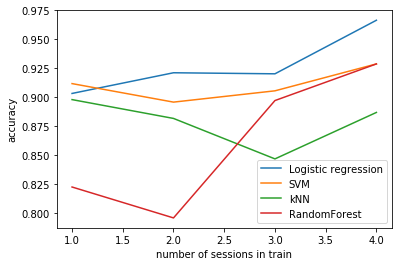

In [27]:
results = []
all_train_sessions = list(range(1, len(sessions)))

clf_lr = LogisticRegression(solver='liblinear', multi_class='ovr')
clf_svm = svm.SVC(kernel='linear')
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_rfc = RandomForestClassifier(n_estimators=100)
classifiers = {'Logistic regression':clf_lr, 'SVM':clf_svm, 'kNN':clf_knn, 'RandomForest':clf_rfc}

for clf in classifiers:
    print(clf)
    classifier_results = []
    for train_sessions_num in all_train_sessions:
        print('number of sessions in train:', train_sessions_num)
        train = np.concatenate(sessions[:train_sessions_num])
        test = np.concatenate(sessions[train_sessions_num:])

        accuracy = gesture_classification(train, test, 200, 200, classifiers[clf])
        classifier_results.append(accuracy)
        print('accuracy:', accuracy)
        print()
    
    plt.plot(range(1, 5), classifier_results, label=clf)
    print()

plt.legend()
plt.xlabel('number of sessions in train')
plt.ylabel('accuracy')
plt.show()